In [2]:
import torchvision
import torch
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pickle as pkl
import pandas as pd
import numpy as np

In [4]:
with open('/content/all_embeddinds/all_valid_embedings_sprase.pkl', 'rb') as f:
  all_valid_embedings = pkl.load(f)

In [5]:
with open('/content/all_embeddinds/all_test_embedings_sprase.pkl', 'rb') as f:
  all_test_embedings = pkl.load(f)

In [2]:
df = pd.read_csv("/content/celeba_metadata.csv")

In [7]:
df

,Unnamed: 0,image_id,img_filename,y,split,place
0,0,0,img_align_celeba/000001.jpg,0,0,0
1,1,1,img_align_celeba/000002.jpg,0,0,0
2,2,2,img_align_celeba/000003.jpg,0,0,1
3,3,3,img_align_celeba/000004.jpg,0,0,0
4,4,4,img_align_celeba/000005.jpg,0,0,0
...,...,...,...,...,...,...
202594,202594,202594,img_align_celeba/202595.jpg,1,2,0
202595,202595,202595,img_align_celeba/202596.jpg,1,2,1
202596,202596,202596,img_align_celeba/202597.jpg,0,2,1
202597,202597,202597,img_align_celeba/202598.jpg,0,2,0


In [8]:
y_train = df[df['split'] == 0]['y'].values

In [9]:
y_valid = df[df['split'] == 1]['y'].values

In [10]:
y_test = df[df['split'] == 2]['y'].values

# Train Logreg

In [57]:
def count_accuracy(df, y_pred, test_id=2, pairs=[(0,0), (0,1), (1,0), (1,1)], flag_print_acc=True):
  mask_test = df['split'] == test_id
  acc_groups = dict()
  groups_count = dict()
  for hair, gender in pairs:
    mask_hair = df[mask_test]['place'] == hair
    mask_gender = df[mask_test]['y'] == gender
    y_test_tmp = df[mask_test & mask_hair & mask_gender]['y']
    y_pred_tmp = y_pred[mask_hair & mask_gender]

    corr = (y_test_tmp ==  y_pred_tmp).sum()
    n = len(y_test_tmp)

    groups_count[(hair, gender)] = (corr, n)
    acc = corr/n
    if flag_print_acc:
      print('hair: ', hair, 'gender:',  gender)
      print('accuracy: ', acc)
    acc_groups[(hair, gender)] = acc

  groups = acc_groups.keys()

  all_correct = sum([groups_count[g][0] for g in groups])
  all_total = sum([groups_count[g][1] for g in groups])
  if flag_print_acc:
    print("mean_accuracy :", all_correct / all_total)
  return acc_groups

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')
clf.fit(all_valid_embedings, y_valid)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

In [12]:
y_pred_test = clf.predict(all_test_embedings)

In [49]:
acc_groups = count_accuracy(df, y_pred_test, test_id=2)

hair:  0 gender: 0
accuracy:  0.9655984437391215
hair:  0 gender: 1
accuracy:  0.8415322580645161
hair:  1 gender: 0
accuracy:  0.9930988719309887
hair:  1 gender: 1
accuracy:  0.4388888888888889
mean_accuracy : 0.9558160504959423


In [73]:
dict_gender = {0: 'women', 1: 'men'}
dict_hair = {0: 'non-blonde', 1: 'blonde'}

In [102]:
c_grid = np.logspace(-5, 0, 50)
all_acc = dict()
for pair in [(0,0), (0,1), (1,0), (1,1)]:
  all_acc[pair] = []

for c in c_grid:
  clf_tmp = LogisticRegression(random_state=0, penalty='l1', solver='liblinear', C=c)
  clf_tmp.fit(all_valid_embedings, y_valid)
  y_pred_test_tmp = clf_tmp.predict(all_test_embedings)
  acc_groups = count_accuracy(df, y_pred_test_tmp, test_id=2, flag_print_acc=False)
  [all_acc[keys].append(values) for keys, values in acc_groups.items()]

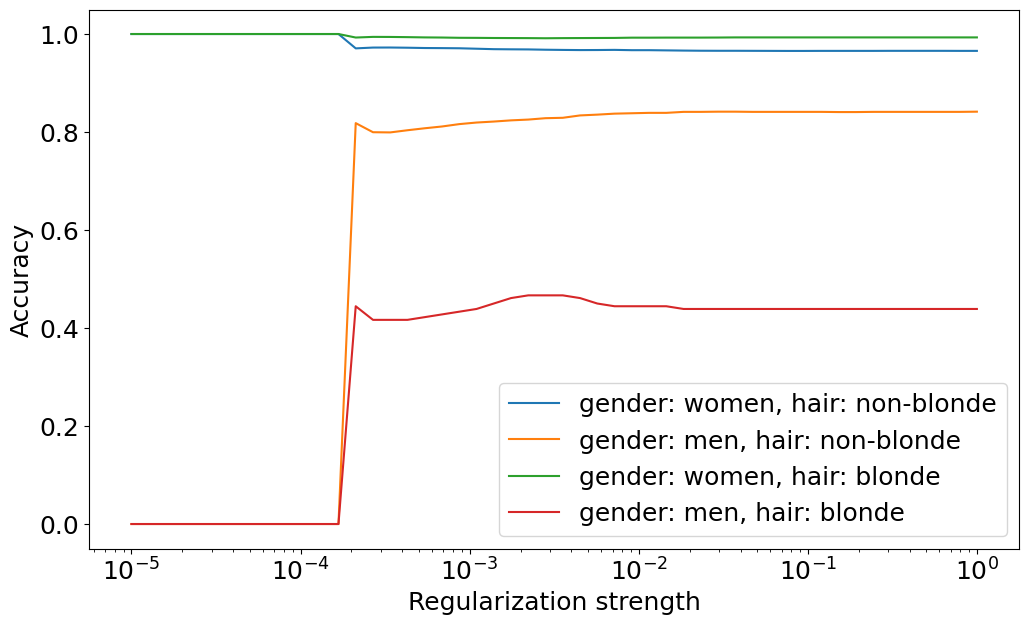

In [103]:
# Importing libraries
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
for keys, values in all_acc.items():
  plt.plot(c_grid, values, label='gender: '+str(dict_gender[keys[1]])+', hair: '+str(dict_hair[keys[0]]))

plt.xlabel("Regularization strength", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xscale('log')

plt.legend(fontsize=18)
plt.show()

# Train DFR

In [ ]:
dict_gender = {0: 'women', 1: 'men'}
dict_hair = {0: 'non-blonde', 1: 'blonde'}

In [110]:
mask_valid = df['split'] == 1
mask_hair = df['y'] == 1
mask_gender = df['place'] == 1
len_of_one_group = len(df[mask_valid  & mask_hair & mask_gender])

In [112]:
all_valid_embedings.shape

(19867, 8096)

In [122]:
all_valid_embedings_balance = np.empty((0, 8096))
y_valid_balance = np.empty((0))
for pair in [(0,0), (0,1), (1,0), (1,1)]:
  mask_hair = df[mask_valid]['y'] == pair[0]
  mask_gender = df[mask_valid]['place'] == pair[1]
  mask_tmp = mask_hair & mask_gender

  all_valid_embedings_balance = np.concatenate((all_valid_embedings_balance, all_valid_embedings[mask_tmp][:len_of_one_group]))
  y_valid_balance = np.concatenate((y_valid_balance, y_valid[mask_tmp][:len_of_one_group]))


In [126]:
index_permut = np.random.permutation(len(all_valid_embedings_balance))

In [128]:
all_valid_embedings_balance[index_permut]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [132]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, penalty='l1', solver='liblinear')
clf.fit(all_valid_embedings_balance[index_permut], y_valid_balance[index_permut])

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

In [133]:
y_pred_test = clf.predict(all_test_embedings)

In [134]:
acc_groups = count_accuracy(df, y_pred_test, test_id=2)

hair:  0 gender: 0
accuracy:  0.9108221562404013
hair:  0 gender: 1
accuracy:  0.9439516129032258
hair:  1 gender: 0
accuracy:  0.9596549435965495
hair:  1 gender: 1
accuracy:  0.7777777777777778
mean_accuracy : 0.9321711251377618
